# Austin Traffic Data Analysis: Part 2 - Advanced Analysis with API Access

Building on our fundamentals, we'll now create comprehensive visualizations and learn to access live data through APIs using the requests library.

## Setup and Data Loading

In [4]:
!pip install requests


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from datetime import datetime, timedelta

# Load and prepare data
df = pd.read_csv('Real-Time_Traffic_Incident_Reports_20250805.csv')

# Extract temporal information
df['Date'] = pd.to_datetime(df['Published Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Filter to Austin area
valid_coords = (df['Latitude'] > 30.0) & (df['Latitude'] < 30.6) & \
               (df['Longitude'] > -98.0) & (df['Longitude'] < -97.0)
austin_data = df[valid_coords]

## API Access: Live Data from Austin Open Data Portal

The Austin Open Data Portal provides real-time traffic incident data through a REST API. We'll use the `requests` library to fetch this data.

In [6]:
# Austin Open Data Portal API endpoint for traffic incidents
# Dataset: Real-Time Traffic Incident Reports (dx9v-zd7x)
api_endpoint = "https://data.austintexas.gov/resource/dx9v-zd7x.json"

# Basic API request - fetch recent incidents
print("Fetching recent traffic incidents from Austin Open Data API...")

# Simple request without parameters
response = requests.get(api_endpoint)

if response.status_code == 200:
    basic_data = pd.DataFrame(response.json())
    print(f"Default fetch returned {len(basic_data)} incidents")
    print(f"\nColumns: {list(basic_data.columns)}")
    print(f"\nFirst incident:")
    print(basic_data.iloc[0])
else:
    print(f"Request failed with status: {response.status_code}")

Fetching recent traffic incidents from Austin Open Data API...
Default fetch returned 1000 incidents

Columns: ['traffic_report_id', 'published_date', 'issue_reported', 'location', 'latitude', 'longitude', 'address', 'traffic_report_status', 'traffic_report_status_date_time', 'agency', ':@computed_region_pgdr_vyqg', ':@computed_region_u569_ruue', ':@computed_region_ap3j_c5bq', ':@computed_region_99rk_ypn4', ':@computed_region_g44y_bfnm', ':@computed_region_jcrc_4uuy', ':@computed_region_q9nd_rr82', ':@computed_region_e9j2_6w3z', ':@computed_region_m2th_e4b7', ':@computed_region_rxpj_nzrk']

First incident:
traffic_report_id                  F350D780EA8AAA48030B4DB64F790C14DBCD757F_17096...
published_date                                              2024-03-06T01:29:39.000Z
issue_reported                                                       Stalled Vehicle
location                           {'type': 'Point', 'coordinates': [-97.705874, ...
latitude                                      

## API with Query Parameters

The API supports SoQL (Socrata Query Language) parameters for filtering and sorting data.

In [7]:
# Fetch more records with specific filters
params = {
    '$limit': 2000,  # Number of records to fetch
    '$where': "published_date > '2024-01-01T00:00:00.000'",  # Filter for 2024 data
    '$order': 'published_date DESC'  # Sort by most recent first
}

response = requests.get(api_endpoint, params=params)

if response.status_code == 200:
    api_data = pd.DataFrame(response.json())
    print(f"Successfully fetched {len(api_data)} incidents from 2024")
    
    # Convert data types
    api_data['latitude'] = pd.to_numeric(api_data['latitude'], errors='coerce')
    api_data['longitude'] = pd.to_numeric(api_data['longitude'], errors='coerce')
    api_data['published_date'] = pd.to_datetime(api_data['published_date'])
    
    # Show sample data
    print("\nSample of fetched data:")
    print(api_data[['published_date', 'issue_reported', 'address']].head())
else:
    print(f"Request failed: {response.status_code}")
    api_data = pd.DataFrame()

Successfully fetched 2000 incidents from 2024

Sample of fetched data:
             published_date  issue_reported                        address
0 2025-08-13 13:08:20+00:00  Traffic Hazard  9400-9439 MIDDLE FISKVILLE RD
1 2025-08-13 13:08:06+00:00       COLLISION    10800-10924 E Us 290 Hwy Wb
2 2025-08-13 13:00:54+00:00       COLLISION          5400-5829 N FM 620 RD
3 2025-08-13 12:59:39+00:00       COLLISION       12400-12425 Entrada Blvd
4 2025-08-13 12:58:04+00:00       COLLISION        14100-14129 Immanuel Rd


## Filtering API Data by Location

We can filter data directly in the API request to get only Austin-area incidents.

In [8]:
# Fetch incidents within Austin boundaries
austin_params = {
    '$limit': 1000,
    '$where': "latitude > 30.0 AND latitude < 30.6 AND longitude > -98.0 AND longitude < -97.0 AND published_date > '2024-06-01'",
    '$select': 'traffic_report_id, published_date, issue_reported, latitude, longitude, address, traffic_report_status'
}

austin_response = requests.get(api_endpoint, params=austin_params)

if austin_response.status_code == 200:
    austin_api_data = pd.DataFrame(austin_response.json())
    print(f"Fetched {len(austin_api_data)} Austin-area incidents")
    
    # Process the data
    austin_api_data['latitude'] = pd.to_numeric(austin_api_data['latitude'])
    austin_api_data['longitude'] = pd.to_numeric(austin_api_data['longitude'])
    austin_api_data['published_date'] = pd.to_datetime(austin_api_data['published_date'])
    
    # Extract hour for analysis
    austin_api_data['hour'] = austin_api_data['published_date'].dt.hour
    
    print(f"\nDate range: {austin_api_data['published_date'].min()} to {austin_api_data['published_date'].max()}")
else:
    print(f"Request failed: {austin_response.status_code}")

Fetched 1000 Austin-area incidents

Date range: 2024-06-01 00:00:46+00:00 to 2024-06-08 02:24:02+00:00


## Visualizing Live API Data

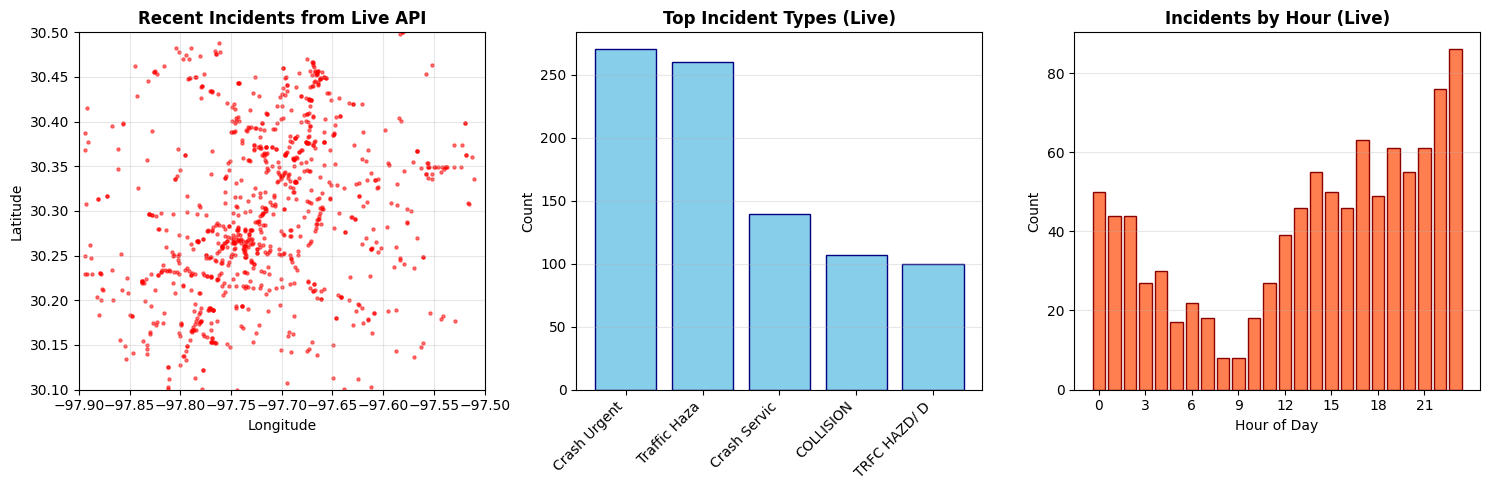

In [9]:
if len(austin_api_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Map of recent incidents
    axes[0].scatter(austin_api_data['longitude'], austin_api_data['latitude'], 
                   s=5, alpha=0.5, c='red')
    axes[0].set_title('Recent Incidents from Live API', fontweight='bold')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_xlim(-97.9, -97.5)
    axes[0].set_ylim(30.1, 30.5)
    axes[0].grid(True, alpha=0.3)
    
    # Incident types distribution
    incident_counts = austin_api_data['issue_reported'].value_counts().head(5)
    axes[1].bar(range(len(incident_counts)), incident_counts.values, 
               color='skyblue', edgecolor='navy')
    axes[1].set_xticks(range(len(incident_counts)))
    axes[1].set_xticklabels([t[:12] for t in incident_counts.index], 
                           rotation=45, ha='right')
    axes[1].set_title('Top Incident Types (Live)', fontweight='bold')
    axes[1].set_ylabel('Count')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Hourly distribution
    hourly_counts = austin_api_data['hour'].value_counts().sort_index()
    axes[2].bar(hourly_counts.index, hourly_counts.values, 
               color='coral', edgecolor='darkred')
    axes[2].set_title('Incidents by Hour (Live)', fontweight='bold')
    axes[2].set_xlabel('Hour of Day')
    axes[2].set_ylabel('Count')
    axes[2].set_xticks(range(0, 24, 3))
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Fetching Today's Incidents

Incidents in last 24 hours: 167

Most recent 5 incidents:
13:08 - Traffic Hazard: 9400-9439 MIDDLE FISKVILLE RD...
13:08 - COLLISION: 10800-10924 E Us 290 Hwy Wb...
13:00 - COLLISION: 5400-5829 N FM 620 RD...
12:59 - COLLISION: 12400-12425 Entrada Blvd...
12:58 - COLLISION: 14100-14129 Immanuel Rd...


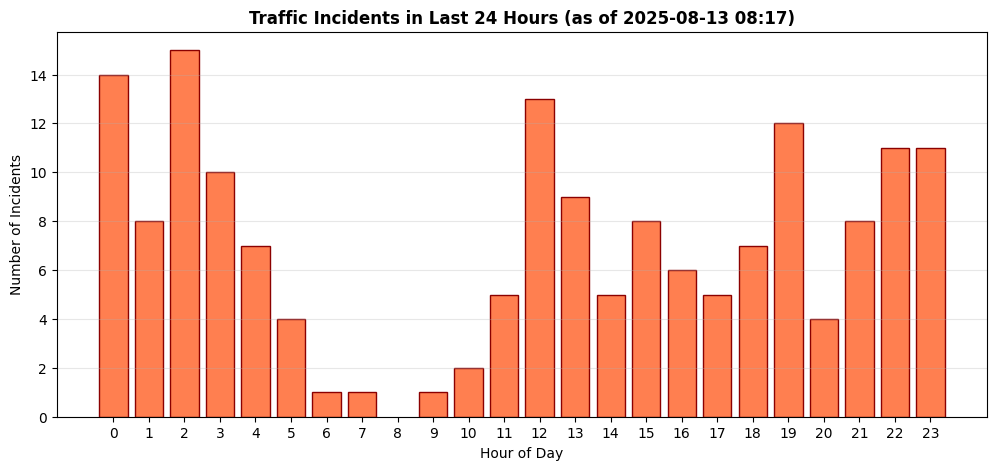

In [10]:
# Get today's date for the query
today = datetime.now()
yesterday = today - timedelta(days=1)
yesterday_str = yesterday.strftime('%Y-%m-%dT00:00:00.000')

# Fetch incidents from last 24 hours
today_params = {
    '$limit': 500,
    '$where': f"published_date > '{yesterday_str}'",
    '$order': 'published_date DESC'
}

today_response = requests.get(api_endpoint, params=today_params)

if today_response.status_code == 200:
    today_data = pd.DataFrame(today_response.json())
    
    if len(today_data) > 0:
        print(f"Incidents in last 24 hours: {len(today_data)}")
        
        today_data['published_date'] = pd.to_datetime(today_data['published_date'])
        today_data['hour'] = today_data['published_date'].dt.hour
        
        # Show most recent incidents
        print("\nMost recent 5 incidents:")
        recent = today_data[['published_date', 'issue_reported', 'address']].head()
        for idx, row in recent.iterrows():
            time_str = row['published_date'].strftime('%H:%M')
            print(f"{time_str} - {row['issue_reported']}: {row['address'][:40]}...")
        
        # Hourly distribution for today
        hourly_today = today_data['hour'].value_counts().sort_index()
        
        plt.figure(figsize=(12, 5))
        plt.bar(hourly_today.index, hourly_today.values, 
               color='coral', edgecolor='darkred')
        plt.title(f"Traffic Incidents in Last 24 Hours (as of {today.strftime('%Y-%m-%d %H:%M')})", 
                 fontweight='bold')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Incidents')
        plt.xticks(range(0, 24))
        plt.grid(axis='y', alpha=0.3)
        plt.show()
    else:
        print("No incidents in the last 24 hours")
else:
    print(f"Failed to fetch today's data: {today_response.status_code}")

## Aggregating Data by Issue Type

Top incident types in 2024 (via API aggregation):
Traffic Hazard                 20,447 incidents
Crash Urgent                   20,242 incidents
COLLISION                      10,014 incidents
Crash Service                  9,484 incidents
TRFC HAZD/ DEBRIS              7,109 incidents
Stalled Vehicle                2,630 incidents
COLLISION WITH INJURY          2,451 incidents
COLLISN/ LVNG SCN              2,073 incidents
LOOSE LIVESTOCK                1,735 incidents
VEHICLE FIRE                   419 incidents


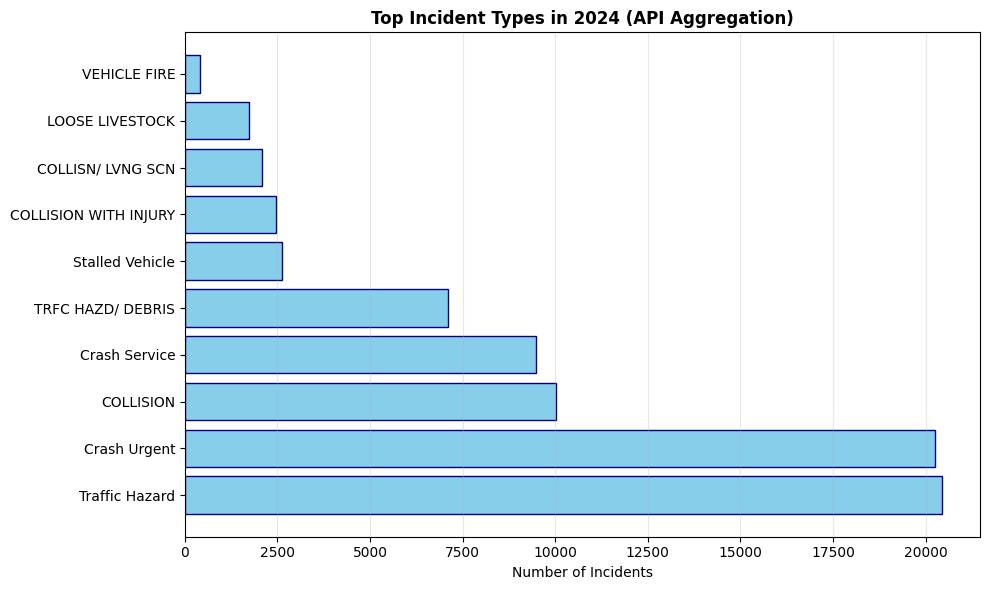

In [11]:
# Use API to get aggregated counts by issue type
aggregate_params = {
    '$select': 'issue_reported, COUNT(traffic_report_id) as incident_count',
    '$group': 'issue_reported',
    '$order': 'incident_count DESC',
    '$where': "published_date > '2024-01-01'",
    '$limit': 10
}

agg_response = requests.get(api_endpoint, params=aggregate_params)

if agg_response.status_code == 200:
    agg_data = pd.DataFrame(agg_response.json())
    agg_data['incident_count'] = pd.to_numeric(agg_data['incident_count'])
    
    print("Top incident types in 2024 (via API aggregation):")
    print("="*50)
    for idx, row in agg_data.iterrows():
        print(f"{row['issue_reported']:30} {row['incident_count']:,} incidents")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(agg_data)), agg_data['incident_count'], 
            color='skyblue', edgecolor='navy')
    plt.yticks(range(len(agg_data)), agg_data['issue_reported'])
    plt.xlabel('Number of Incidents')
    plt.title('Top Incident Types in 2024 (API Aggregation)', fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"Aggregation request failed: {agg_response.status_code}")

## Comparing Historical Data with Live API Data

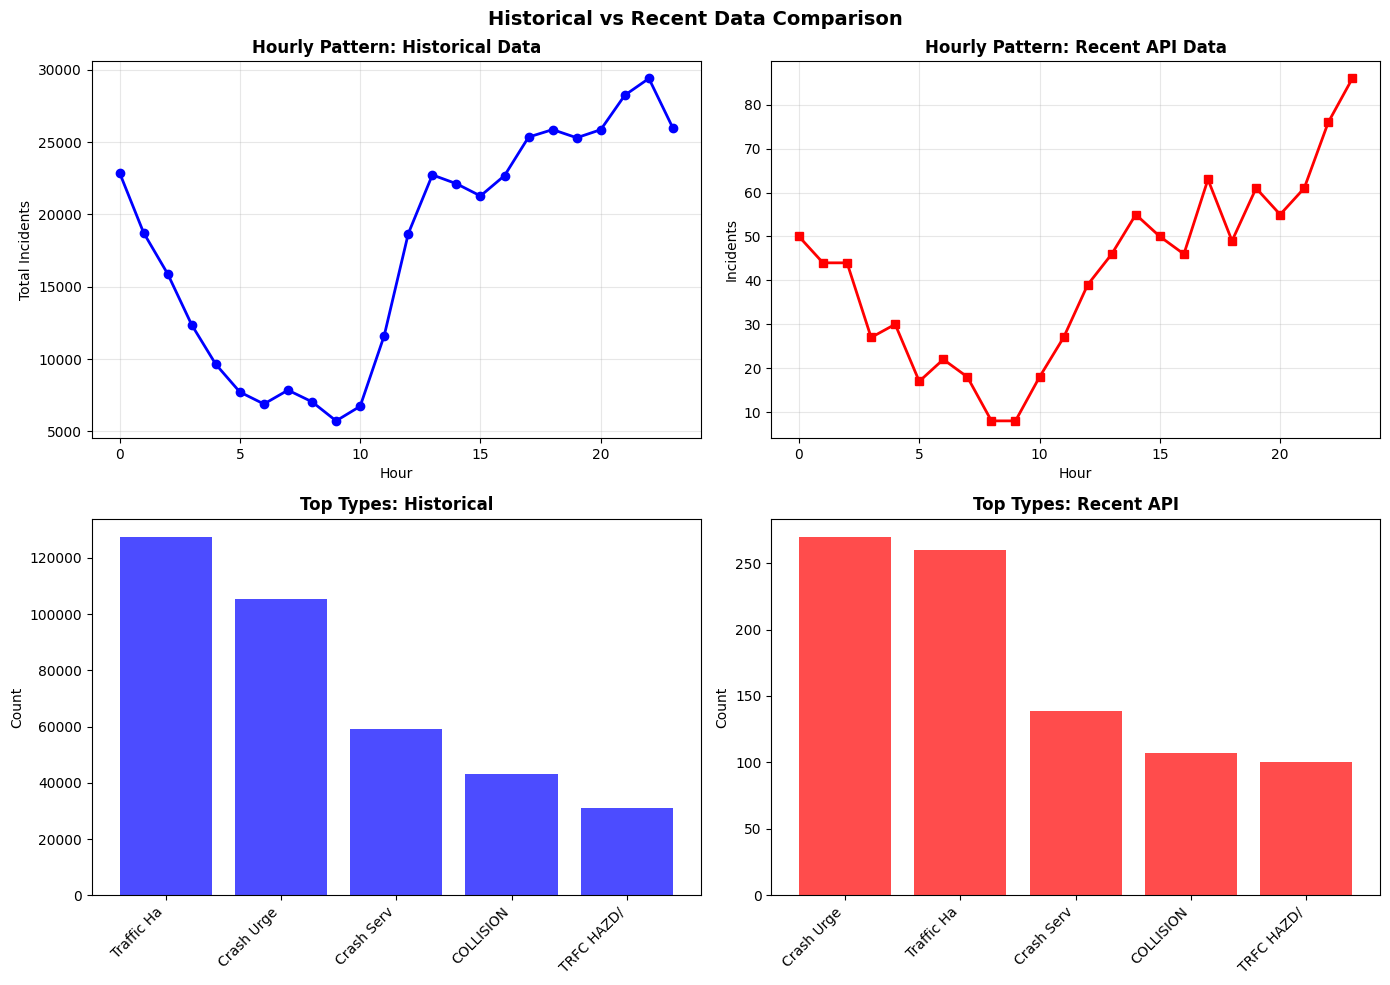

In [12]:
# Compare patterns between historical CSV data and recent API data
if len(austin_api_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Historical data (from CSV)
    hist_hourly = austin_data['Hour'].value_counts().sort_index()
    axes[0, 0].plot(hist_hourly.index, hist_hourly.values, 
                   'b-o', label='Historical', linewidth=2)
    axes[0, 0].set_title('Hourly Pattern: Historical Data', fontweight='bold')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Total Incidents')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Recent data (from API)
    api_hourly = austin_api_data['hour'].value_counts().sort_index()
    axes[0, 1].plot(api_hourly.index, api_hourly.values, 
                   'r-s', label='Recent (API)', linewidth=2)
    axes[0, 1].set_title('Hourly Pattern: Recent API Data', fontweight='bold')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Incidents')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Incident type comparison
    hist_types = austin_data['Issue Reported'].value_counts().head(5)
    api_types = austin_api_data['issue_reported'].value_counts().head(5)
    
    axes[1, 0].bar(range(len(hist_types)), hist_types.values, 
                  color='blue', alpha=0.7)
    axes[1, 0].set_xticks(range(len(hist_types)))
    axes[1, 0].set_xticklabels([t[:10] for t in hist_types.index], 
                              rotation=45, ha='right')
    axes[1, 0].set_title('Top Types: Historical', fontweight='bold')
    axes[1, 0].set_ylabel('Count')
    
    axes[1, 1].bar(range(len(api_types)), api_types.values, 
                  color='red', alpha=0.7)
    axes[1, 1].set_xticks(range(len(api_types)))
    axes[1, 1].set_xticklabels([t[:10] for t in api_types.index], 
                              rotation=45, ha='right')
    axes[1, 1].set_title('Top Types: Recent API', fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    
    plt.suptitle('Historical vs Recent Data Comparison', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Building a Real-Time Dashboard Function

/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_90311/4125986332.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timeline = data['published_date'].dt.floor('H').value_counts().sort_index()


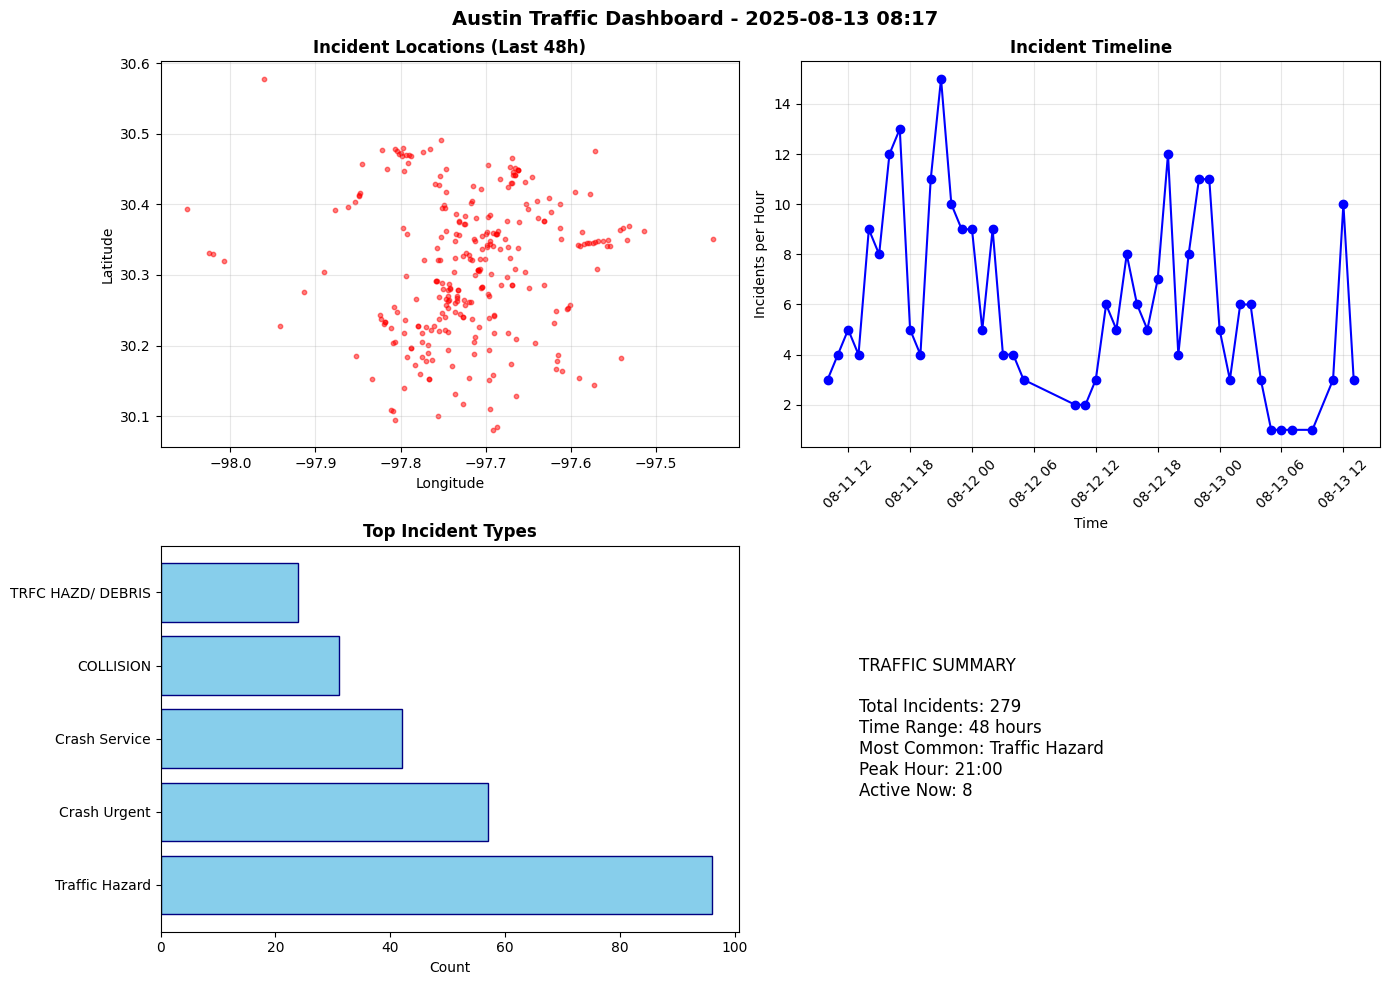

In [13]:
def fetch_traffic_dashboard(hours_back=24):
    """
    Fetch and display a traffic dashboard for the specified time period.
    
    Parameters:
    hours_back (int): Number of hours to look back from now
    """
    # Calculate time range
    end_time = datetime.now()
    start_time = end_time - timedelta(hours=hours_back)
    start_str = start_time.strftime('%Y-%m-%dT%H:%M:%S.000')
    
    # Fetch data
    params = {
        '$limit': 1000,
        '$where': f"published_date > '{start_str}'",
        '$order': 'published_date DESC'
    }
    
    response = requests.get(api_endpoint, params=params)
    
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code}")
        return
    
    data = pd.DataFrame(response.json())
    
    if len(data) == 0:
        print(f"No incidents in the last {hours_back} hours")
        return
    
    # Process data
    data['published_date'] = pd.to_datetime(data['published_date'])
    data['hour'] = data['published_date'].dt.hour
    data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
    data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')
    
    # Create dashboard
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Map
    valid_coords = data['latitude'].notna() & data['longitude'].notna()
    map_data = data[valid_coords]
    axes[0, 0].scatter(map_data['longitude'], map_data['latitude'], 
                      s=10, alpha=0.5, c='red')
    axes[0, 0].set_title(f'Incident Locations (Last {hours_back}h)', fontweight='bold')
    axes[0, 0].set_xlabel('Longitude')
    axes[0, 0].set_ylabel('Latitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Timeline
    timeline = data['published_date'].dt.floor('H').value_counts().sort_index()
    axes[0, 1].plot(timeline.index, timeline.values, 'b-o')
    axes[0, 1].set_title('Incident Timeline', fontweight='bold')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Incidents per Hour')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top incident types
    top_types = data['issue_reported'].value_counts().head(5)
    axes[1, 0].barh(range(len(top_types)), top_types.values, 
                   color='skyblue', edgecolor='navy')
    axes[1, 0].set_yticks(range(len(top_types)))
    axes[1, 0].set_yticklabels(top_types.index)
    axes[1, 0].set_title('Top Incident Types', fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    
    # Summary statistics
    axes[1, 1].axis('off')
    summary_text = f"""TRAFFIC SUMMARY
    
Total Incidents: {len(data)}
Time Range: {hours_back} hours
Most Common: {top_types.index[0]}
Peak Hour: {data['hour'].mode()[0] if len(data) > 0 else 'N/A'}:00
Active Now: {len(data[data['traffic_report_status'] == 'ACTIVE']) if 'traffic_report_status' in data.columns else 'N/A'}
"""
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
                   verticalalignment='center')
    
    plt.suptitle(f'Austin Traffic Dashboard - {end_time.strftime("%Y-%m-%d %H:%M")}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return data

# Test the dashboard function
dashboard_data = fetch_traffic_dashboard(hours_back=48)

## API Rate Limiting and Error Handling

In [14]:
def safe_api_request(endpoint, params, max_retries=3):
    """
    Make an API request with error handling and retries.
    
    Parameters:
    endpoint (str): API endpoint URL
    params (dict): Query parameters
    max_retries (int): Maximum number of retry attempts
    
    Returns:
    DataFrame or None
    """
    for attempt in range(max_retries):
        try:
            response = requests.get(endpoint, params=params, timeout=10)
            
            if response.status_code == 200:
                return pd.DataFrame(response.json())
            elif response.status_code == 429:
                print(f"Rate limited. Waiting before retry...")
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                print(f"Request failed with status {response.status_code}")
                return None
                
        except requests.exceptions.Timeout:
            print(f"Request timed out. Attempt {attempt + 1}/{max_retries}")
        except requests.exceptions.ConnectionError:
            print(f"Connection error. Attempt {attempt + 1}/{max_retries}")
        except Exception as e:
            print(f"Unexpected error: {e}")
            return None
    
    print("Max retries reached. Request failed.")
    return None

# Example usage
test_params = {
    '$limit': 100,
    '$where': "published_date > '2024-07-01'"
}

safe_data = safe_api_request(api_endpoint, test_params)
if safe_data is not None:
    print(f"Successfully fetched {len(safe_data)} records")

Successfully fetched 100 records


## Saving API Data for Offline Analysis

In [15]:
# Save the fetched API data to CSV for offline analysis
if len(austin_api_data) > 0:
    # Add timestamp to filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'austin_traffic_api_{timestamp}.csv'
    
    # Save to CSV
    austin_api_data.to_csv(filename, index=False)
    print(f"API data saved to '{filename}'")
    print(f"Records saved: {len(austin_api_data)}")
    
    # Create a summary report
    summary = {
        'fetch_time': datetime.now().isoformat(),
        'total_records': len(austin_api_data),
        'date_range_start': str(austin_api_data['published_date'].min()),
        'date_range_end': str(austin_api_data['published_date'].max()),
        'top_incident_type': austin_api_data['issue_reported'].mode()[0] if len(austin_api_data) > 0 else 'N/A',
        'unique_locations': austin_api_data['address'].nunique() if 'address' in austin_api_data.columns else 0
    }
    
    # Save summary as JSON
    with open(f'api_summary_{timestamp}.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\nSummary saved to 'api_summary_{timestamp}.json'")
    print(json.dumps(summary, indent=2))

API data saved to 'austin_traffic_api_20250813_081733.csv'
Records saved: 1000

Summary saved to 'api_summary_20250813_081733.json'
{
  "fetch_time": "2025-08-13T08:17:33.663030",
  "total_records": 1000,
  "date_range_start": "2024-06-01 00:00:46+00:00",
  "date_range_end": "2024-06-08 02:24:02+00:00",
  "top_incident_type": "Crash Urgent",
  "unique_locations": 968
}


## Conclusion

We've demonstrated how to:

1. **Access Live Data**: Using the `requests` library to fetch real-time traffic data from Austin's Open Data Portal
2. **Query Parameters**: Filter and sort data using SoQL parameters
3. **Data Processing**: Convert API responses to DataFrames for analysis
4. **Visualization**: Create dashboards from live data
5. **Error Handling**: Implement robust API requests with retries
6. **Data Persistence**: Save API data for offline analysis

The API provides access to real-time data that's updated every 5 minutes, enabling:
- Real-time traffic monitoring
- Historical trend analysis
- Infrastructure planning based on current patterns
- Emergency response optimization

This approach transforms static analysis into dynamic, real-time engineering intelligence.